# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
! pip install -q kaggle

#from google.colab import files
#_ = files.upload()

! mkdir -p ~/.kaggle
! cp "/content/gdrive/Shareddrives/HLT-GoEmotions/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install tensorflow==2.4.1 > null
!pip install tensorflow-text==2.4.1 > null
!pip install keras==2.3.1 > null

In [ ]:
! pip install datasets > null
! pip install contractions > null

In [ ]:
import contractions
from datasets import list_datasets, load_dataset
import matplotlib.pyplot as plt
from nltk import RegexpTokenizer
import numpy as np
import pandas as pd
import pickle
import re
import time
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics as skm
from sklearn.metrics import label_ranking_average_precision_score
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_text as text
from tqdm import tqdm

import math

Using TensorFlow backend.


# GO_EMOTIONS Dataset from HuggingFace

These are the lists of the emotions and their division in Positive, Negative and Ambigous.

In [ ]:
EMOTIONS = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
            'confusion',	'curiosity',	'desire',	'disappointment',	'disapproval',
            'disgust','embarrassment','excitement',	'fear','gratitude','grief',
            'joy','love', 'nervousness', 'optimism','pride', 'realization',
            'relief', 'remorse', 'sadness', 'surprise', 'neutral']

POSITIVE = [0,1,4,5,8,13,15,17,18,20,21,23]
NEGATIVE = [2,3,9,10,11,12,14,16,19,24,25]
AMBIGOUS = [5,6,22,26,27]

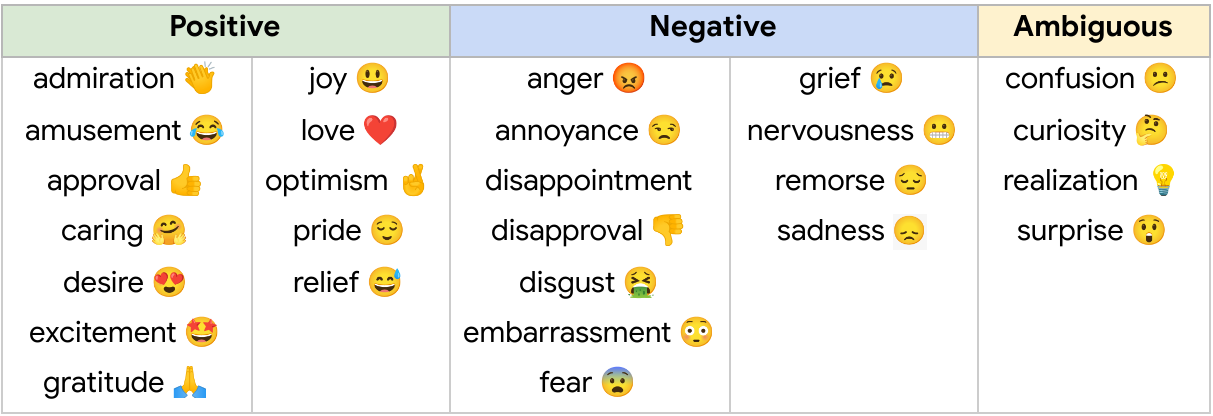

In [ ]:
dataset = load_dataset('go_emotions')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The Dataset is already splitted into *Train*, *Validation* and *Test*, with these percentages: **80%**, **10%**, **10%**.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

Let's see an example:

In [ ]:
dataset['train'][6]

{'text': 'Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝',
 'labels': [15],
 'id': 'ee3b6wu'}

In [ ]:
dataset['train'][1982]

{'text': 'Give me [NAME]. We need some thump when we clear the benches.',
 'labels': [4, 8],
 'id': 'ef4bpxo'}

In [ ]:
dataset['train'][60]

{'text': 'LOL. Super cute!', 'labels': [0, 1], 'id': 'ed7nnui'}

In [ ]:
dataset['train'][40010]

{'text': "I wish. It's been over 72 hours for me now, nothing. Less than .5 ETH, BCH and BSV - hasn't moved.",
 'labels': [8],
 'id': 'eerlvg9'}

In [ ]:
dataset['test'][4321]['text'][25]

'🙄'

In [ ]:
hex(ord(dataset['test'][4321]['text'][25]))

'0x1f644'

Both **emoji** and **emoticon** convey emotional expression in a text message. The main difference between emoji and emoticon: an emoji is a small actual image that is used to express emotions or idea in text messages. where an emoticon is a facial expression representation using keyboard characters and punctuations. For example, ? is an emoji and ‘:)’ is an emoticon that represents a happy face. \\
People may write the emoji in a sentence to express their feelings. In that case, we may lose valuable information if we remove the emojis. In this case, a better approach is to convert emoji to word format so that it preserves the emoji information.

Our decision is to **keep these valuable information**, considering that our main task is the understanding of such feelings that these piece of text could convey.

### Dictionary Emoji to Word

In [ ]:
emoji_to_word = {
    '😀' : 'happy',
    '😃' : 'happy',
    '😄' : 'happy',
    '😁' : 'happy',
    '😆' : 'happy',
    '😅' : 'happy',
    '🤣' : 'happy',
    '😂' : 'happy',
    '🙂' : 'happy',
    '🙃' : 'happy',
    '😉' : 'happy',
    '😊' : 'happy',
    '😇' : 'happy',
    '🥰' : 'love',
    '😍' : 'love',
    '🤩' : 'love',
    '😘' : 'love',
    '😗' : 'love',
    '😚' : 'love',
    '😙' : 'love',
    '😋' : 'joking',
    '😛' : 'joking',
    '😜' : 'joking',
    '🤪' : 'joking',
    '😝' : 'joking',
    '🤑' : 'joking',
    '🤗' : 'caring',
    '🤭' : 'caring',
    '🤫' : 'concerned',
    '🤔' : 'skeptical',
    '🤐' : 'skeptical',
    '🤨' : 'skeptical',
    '😐' : 'skeptical',
    '😑' : 'skeptical',
    '😶' : 'skeptical',
    '😏' : 'skeptical',
    '😒' : 'skeptical',
    '🙄' : 'skeptical',
    '😬' : 'skeptical',
    '🤥' : 'skeptical',
    '😌' : 'sleepy',
    '😔' : 'sleepy',
    '😪' : 'sleepy',
    '🤤' : 'sleepy',
    '😴' : 'sleepy',
    '😷' : 'unwell',
    '🤒' : 'unwell',
    '🤕' : 'unwell',
    '🤢' : 'unwell',
    '🤮' : 'unwell',
    '🤧' : 'unwell',
    '🥵' : 'unwell',
    '🥶' : 'unwell',
    '🥴' : 'unwell',
    '😵' : 'unwell',
    '🤯' : 'unwell',
    '🤠' : 'irriverent',
    '🥳' : 'irriverent',
    '😎' : 'irriverent',
    '🤓' : 'irriverent',
    '🧐' : 'irriverent',
    '😕' : 'concerned',
    '😟' : 'concerned',
    '🙁' : 'concerned',
    '😮' : 'concerned',
    '😲' : 'concerned',
    '😳' : 'concerned',
    '🥺' : 'concerned',
    '😦' : 'concerned',
    '😧' : 'concerned',
    '😨' : 'concerned',
    '😰' : 'concerned',
    '😥' : 'concerned',
    '😢' : 'concerned',
    '😭' : 'concerned',
    '😱' : 'concerned',
    '😖' : 'concerned',
    '😣' : 'concerned',
    '😞' : 'concerned',
    '😓' : 'concerned',
    '😩' : 'concerned',
    '😫' : 'concerned',
    '🥱' : 'concerned',
    '😤' : 'angry',
    '😡' : 'angry',
    '😠' : 'angry',
    '🤬' : 'angry',
    '💌' : 'love',
    '💘' : 'love',
    '💝' : 'love',
    '💖' : 'love',
    '💗' : 'love',
    '💓' : 'love',
    '💞' : 'love',
    '💕' : 'love',
    '💟' : 'love',
    '💔' : 'love'
}

In [ ]:
def convert_emojis_to_word(text):
    for emot in emoji_to_word:
        text = re.sub(r'('+emot+')', "_".join(emoji_to_word[emot].replace(",","").replace(":","").split()), text)
    return text

In [ ]:
text_converted = convert_emojis_to_word(dataset['train'][6]['text'])

In [ ]:
text_converted

'Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait joking'

They are Reddit comment, carefully selected and labeled to be representative of emotions.

### Exploratory Data Analysis

In [ ]:
num_emo_train = {
    '1':0,
    '2':0,
    '3':0,
    '4':0,
    '5':0
}

counter_emo_train = {'admiration':0, 'amusement':0, 'anger':0, 'annoyance':0, 'approval':0, 'caring':0,
            'confusion':0,	'curiosity':0,	'desire':0,	'disappointment':0,	'disapproval':0,
            'disgust':0,'embarrassment':0,'excitement':0,	'fear':0,'gratitude':0,'grief':0,
            'joy':0,'love':0, 'nervousness':0, 'optimism':0,'pride':0, 'realization':0,
            'relief':0, 'remorse':0, 'sadness':0, 'surprise':0, 'neutral':0}

# this metric is computed only for the training set

avg_length_sentence_emo = {'admiration':0, 'amusement':0, 'anger':0, 'annoyance':0, 'approval':0, 'caring':0,
            'confusion':0,	'curiosity':0,	'desire':0,	'disappointment':0,	'disapproval':0,
            'disgust':0,'embarrassment':0,'excitement':0,	'fear':0,'gratitude':0,'grief':0,
            'joy':0,'love':0, 'nervousness':0, 'optimism':0,'pride':0, 'realization':0,
            'relief':0, 'remorse':0, 'sadness':0, 'surprise':0, 'neutral':0}


num_emo_vali = {
    '1':0,
    '2':0,
    '3':0,
    '4':0,
    '5':0
}

counter_emo_val = {'admiration':0, 'amusement':0, 'anger':0, 'annoyance':0, 'approval':0, 'caring':0,
            'confusion':0,	'curiosity':0,	'desire':0,	'disappointment':0,	'disapproval':0,
            'disgust':0,'embarrassment':0,'excitement':0,	'fear':0,'gratitude':0,'grief':0,
            'joy':0,'love':0, 'nervousness':0, 'optimism':0,'pride':0, 'realization':0,
            'relief':0, 'remorse':0, 'sadness':0, 'surprise':0, 'neutral':0}


num_emo_test = {
    '1':0,
    '2':0,
    '3':0,
    '4':0,
    '5':0
}

counter_emo_test = {'admiration':0, 'amusement':0, 'anger':0, 'annoyance':0, 'approval':0, 'caring':0,
            'confusion':0,	'curiosity':0,	'desire':0,	'disappointment':0,	'disapproval':0,
            'disgust':0,'embarrassment':0,'excitement':0,	'fear':0,'gratitude':0,'grief':0,
            'joy':0,'love':0, 'nervousness':0, 'optimism':0,'pride':0, 'realization':0,
            'relief':0, 'remorse':0, 'sadness':0, 'surprise':0, 'neutral':0}

As addressed in this paper *Assessing Emoji Use in Modern Text Processing Tools by Shoeb de Melo*, the tokenization and managing of Emoji in NLP problem is an ongoing problem, for example only few tokenizers support the tokenization of **Emoji**. We decided to use **NLTK** that has good success rate in single emoji.

In [ ]:
# emoji = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
emoji = "['\U0001F600-\U0001F64F']"

tokenizer_word = RegexpTokenizer(r'\w+')
tokenizer_emoji = RegexpTokenizer(emoji)

counter_emoji = 0

for x in tqdm(dataset['train']):
  num_emo_train[str(len(x['labels']))] = num_emo_train[str(len(x['labels']))] + 1
  emoji_tokens = tokenizer_emoji.tokenize(x['text'])
  for emoji in emoji_tokens:
    if emoji != "'":
      counter_emoji = counter_emoji + 1
  for label in x['labels']:
    counter_emo_train[EMOTIONS[label]] = counter_emo_train[EMOTIONS[label]] + 1
    avg_length_sentence_emo[EMOTIONS[label]] = avg_length_sentence_emo[EMOTIONS[label]] + len(tokenizer_word.tokenize(x['text']))

for emotion in EMOTIONS:
  avg_length_sentence_emo[emotion] = avg_length_sentence_emo[emotion] / counter_emo_train[emotion]

for x in tqdm(dataset['validation']):
  num_emo_vali[str(len(x['labels']))] = num_emo_vali[str(len(x['labels']))] + 1
  for label in x['labels']:
    counter_emo_val[EMOTIONS[label]] = counter_emo_val[EMOTIONS[label]] + 1

for x in tqdm(dataset['test']):
  num_emo_test[str(len(x['labels']))] = num_emo_test[str(len(x['labels']))] + 1
  for label in x['labels']:
    counter_emo_test[EMOTIONS[label]] = counter_emo_test[EMOTIONS[label]] + 1

100%|██████████| 5427/5427 [00:00<00:00, 14061.29it/s]


The **number of emoji** is *621*, It is not a negligible number and they can also be used to enforce the sentiment of the sentence.

In [ ]:
counter_emoji

621

As we can notice, the Dataset has a similar number of sample with 1 or 2 or 3 and so on labels in the three sets, as well as, the distribution of emotions label.

In [ ]:
num_emo_train

{'1': 36308, '2': 6541, '3': 532, '4': 28, '5': 1}

In [ ]:
num_emo_test

{'1': 4590, '2': 774, '3': 61, '4': 2, '5': 0}

In [ ]:
num_emo_vali

{'1': 4548, '2': 809, '3': 62, '4': 7, '5': 0}

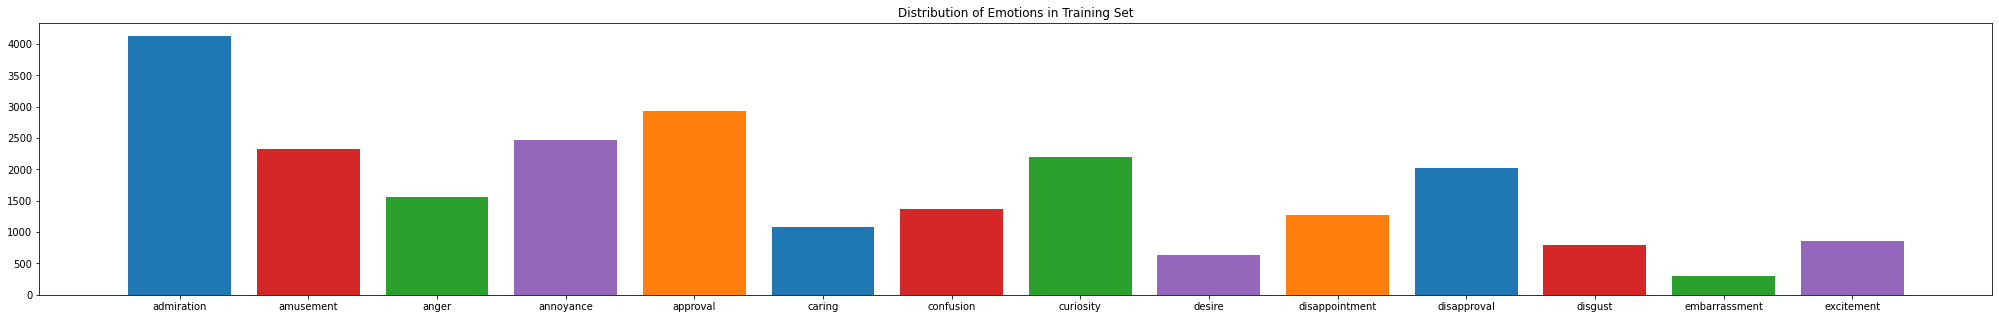

In [ ]:
plt.figure(figsize=(35,5))
plt.bar(range(int(len(counter_emo_train)/2)), list(counter_emo_train.values())[:14], align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange'])
plt.xticks(range(int(len(counter_emo_train)/2)), list(counter_emo_train.keys())[:14])
plt.title("Distribution of Emotions in Training Set")
plt.show()

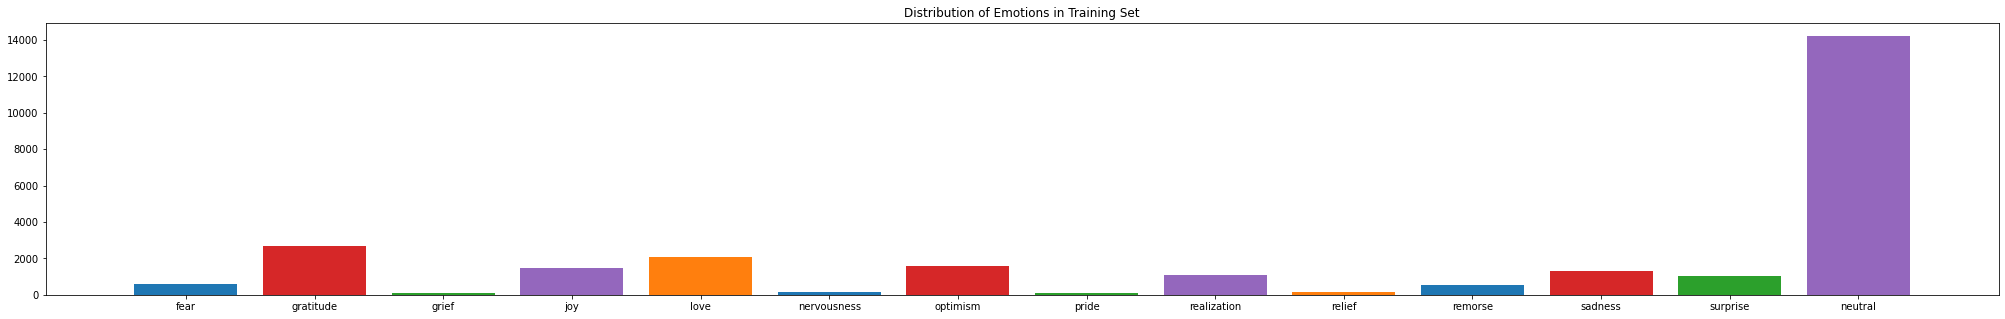

In [ ]:
plt.figure(figsize=(35,5))
plt.bar(range(int(len(counter_emo_train)/2)), list(counter_emo_train.values())[14:], align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange'])
plt.xticks(range(int(len(counter_emo_train)/2)), list(counter_emo_train.keys())[14:])
plt.title("Distribution of Emotions in Training Set")
plt.show()

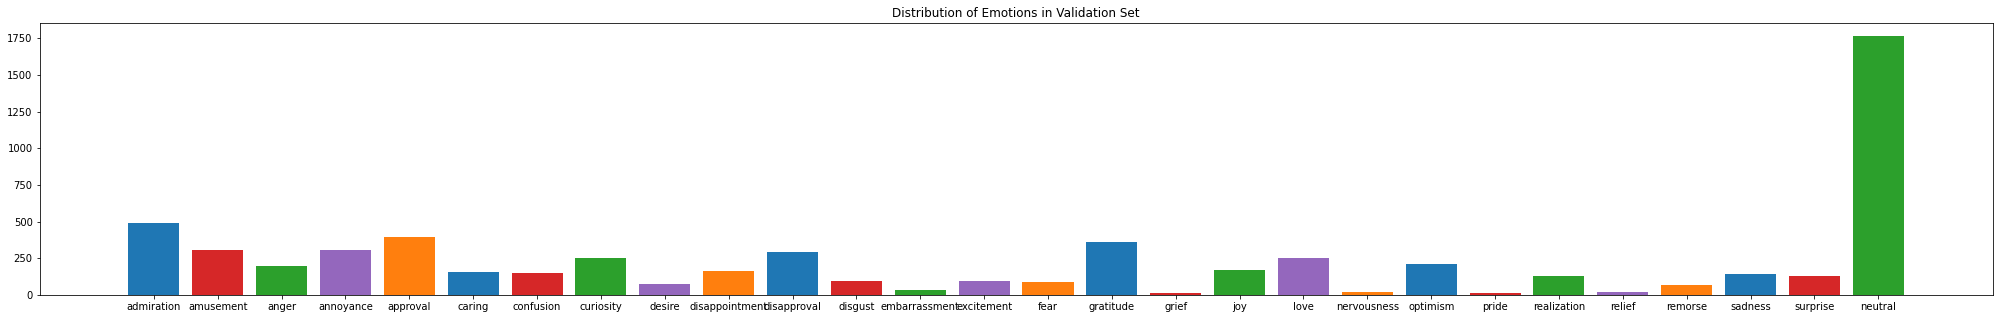

In [ ]:
plt.figure(figsize=(35,5))
plt.bar(range(len(counter_emo_val)), list(counter_emo_val.values()), align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange'])
plt.xticks(range(len(counter_emo_val)), list(counter_emo_val.keys()))
plt.title("Distribution of Emotions in Validation Set")
plt.show()

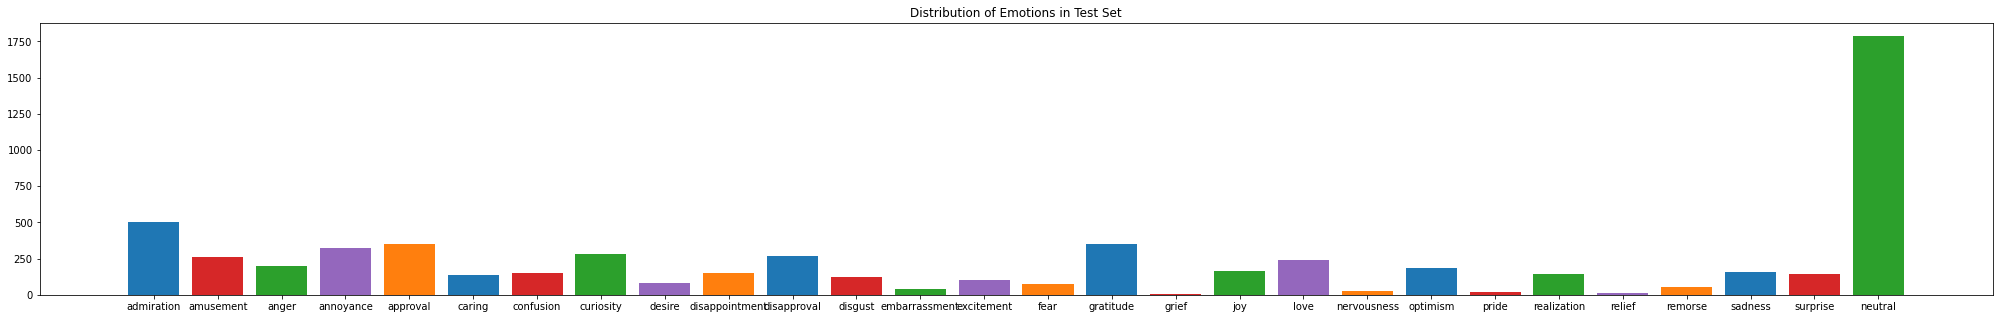

In [ ]:
plt.figure(figsize=(35,5))
plt.bar(range(len(counter_emo_test)), list(counter_emo_test.values()), align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange'])
plt.xticks(range(len(counter_emo_test)), list(counter_emo_test.keys()))
plt.title("Distribution of Emotions in Test Set")
plt.show()

The predominance of Neutral label could be a problem, we will see during the project if It is the case.

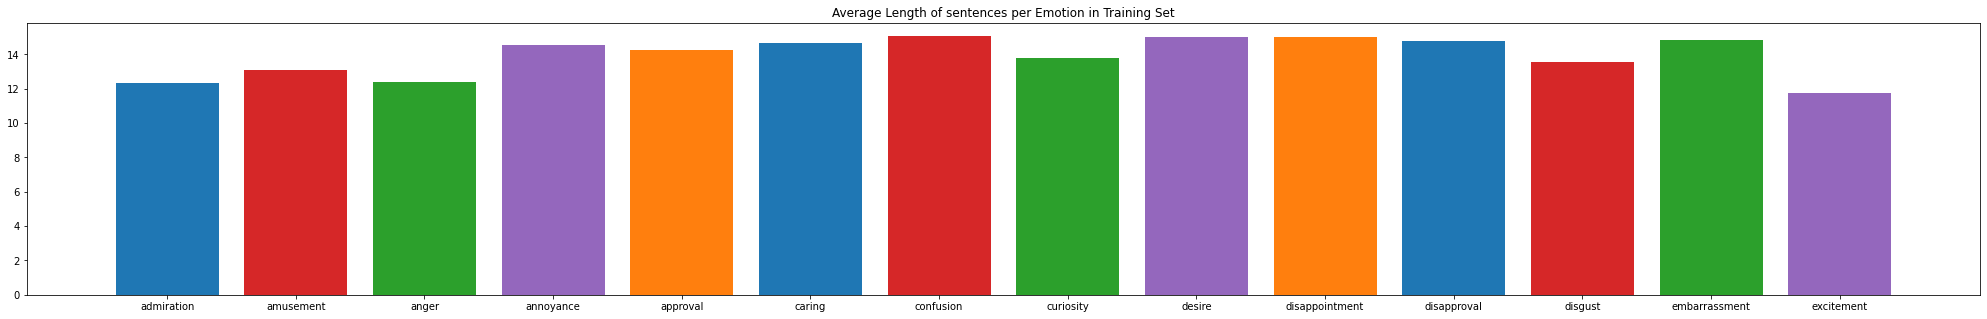

In [ ]:
plt.figure(figsize=(35,5))
plt.bar(range(int(len(counter_emo_train)/2)), list(avg_length_sentence_emo.values())[:14], align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange'])
plt.xticks(range(int(len(counter_emo_train)/2)), list(avg_length_sentence_emo.keys())[:14])
plt.title("Average Length of sentences per Emotion in Training Set")
plt.show()

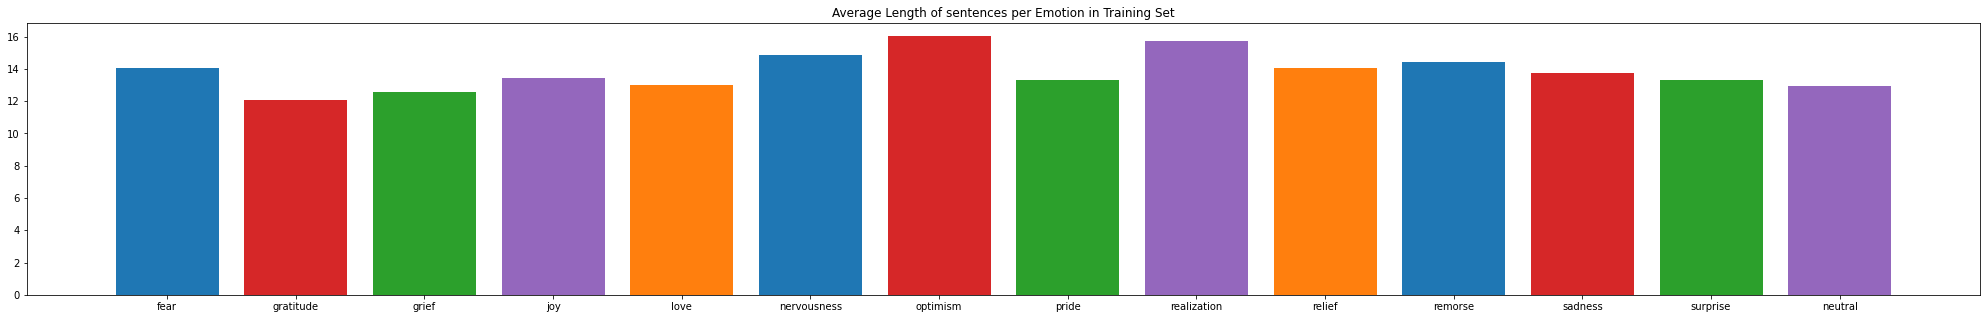

In [ ]:
plt.figure(figsize=(35,5))
plt.bar(range(int(len(counter_emo_train)/2)), list(avg_length_sentence_emo.values())[14:], align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange'])
plt.xticks(range(int(len(counter_emo_train)/2)), list(avg_length_sentence_emo.keys())[14:])
plt.title("Average Length of sentences per Emotion in Training Set")
plt.show()

Can be noticed that the average length of sentences per emotion is quite short, between 10 and 15 words.

#Text Preprocessing

The text preprocessing phase consists of:


*   Eliminate the punctuation
*   Expansion of contracted forms
*   Conversion of the emojis
*   Conversion in lower cases
*   Elimination of special chars



In [ ]:
def text_preprocessing (comment):
  text = convert_emojis_to_word(comment)
  pp_text = []
  for word in text.split():
     # using contractions.fix to expand the shortened words
    pp_text.append(contractions.fix(word.lower()))  
    text = ' '.join(pp_text)
    text = re.sub(r'[^\w\s]', '', text)
  return text

We must create the DataFrame from the dictionary provided by Huggingface

In [ ]:
test_df = pd.DataFrame.from_dict(dataset['test'])
train_df = pd.DataFrame.from_dict(dataset['train'])
validation_df = pd.DataFrame.from_dict(dataset['validation'])

Since the labels from the HuggingFace dataset are saved as array of integers, we must create a one-hot encoding to obtain binary labels. In that way we can use the Binary Crossentropy loss function in the classifiers.

In [ ]:
mlb = MultiLabelBinarizer()

test_df_preprocessed = pd.DataFrame(test_df['text'].apply(text_preprocessing))
test_labels = pd.DataFrame(mlb.fit_transform(test_df['labels']),columns=mlb.classes_)
test = pd.merge(test_df_preprocessed, test_labels, left_index=True, right_index=True)

train_df_preprocessed = pd.DataFrame(train_df['text'].apply(text_preprocessing))
train_labels = pd.DataFrame(mlb.fit_transform(train_df['labels']),columns=mlb.classes_)
train = pd.merge(train_df_preprocessed, train_labels, left_index=True, right_index=True)

validation_df_preprocessed = pd.DataFrame(validation_df['text'].apply(text_preprocessing))
validation_labels = pd.DataFrame(mlb.fit_transform(validation_df['labels']),columns=mlb.classes_)
validation = pd.merge(validation_df_preprocessed, validation_labels, left_index=True, right_index=True)

We have to compute the weights since our dataset is imbalanced, to compute them we used the training set.

In [ ]:
def create_class_weight(labels_dict,mu=0.7):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score 

    return class_weight

In [ ]:
weights = create_class_weight(counter_emo_train)
weights

{'admiration': 2.158890852989586,
 'amusement': 2.732158730093336,
 'anger': 3.128005296588644,
 'annoyance': 2.6729501093226418,
 'approval': 2.4990988725257473,
 'caring': 3.493746651823455,
 'confusion': 3.263818440762169,
 'curiosity': 2.7928101993491983,
 'desire': 4.021894082023994,
 'disappointment': 3.338939071230277,
 'disapproval': 2.873081139364248,
 'disgust': 3.8091003173098166,
 'embarrassment': 4.771190733435295,
 'excitement': 3.7361639914529854,
 'fear': 4.094682871879315,
 'gratitude': 2.5980905399896077,
 'grief': 6.141118117090981,
 'joy': 3.2042263435599234,
 'love': 2.841919903383947,
 'nervousness': 5.385057111120466,
 'optimism': 3.1191107017351927,
 'pride': 5.77539333763233,
 'realization': 3.472808244638285,
 'relief': 5.454485617552229,
 'remorse': 4.18413774428142,
 'sadness': 3.295001368198857,
 'surprise': 3.518899351838552,
 'neutral': 0.9225891615482902}

In [ ]:
class_weights = {0: 2.158890852989586,
 1: 2.732158730093336,
 2: 3.128005296588644,
 3: 2.6729501093226418,
 4: 2.4990988725257473,
 5: 3.493746651823455,
 6: 3.263818440762169,
 7: 2.7928101993491983,
 8: 4.021894082023994,
 9: 3.338939071230277,
 10: 2.873081139364248,
 11: 3.8091003173098166,
 12: 4.771190733435295,
 13: 3.7361639914529854,
 14: 4.094682871879315,
 15: 2.5980905399896077,
 16: 6.141118117090981,
 17: 3.2042263435599234,
 18: 2.841919903383947,
 19: 5.385057111120466,
 20: 3.1191107017351927,
 21: 5.77539333763233,
 22: 3.472808244638285,
 23: 5.454485617552229,
 24: 4.18413774428142,
 25: 3.295001368198857,
 26: 3.518899351838552,
 27: 0.9225891615482902}

# Class Weight

## Transformer Classification

In [ ]:
NUM_CLASSES=28

MODEL_DIR="/content/gdrive/Shareddrives/HLT-GoEmotions/models/"

BATCH_SIZE=32
EPOCHS=10


In [ ]:
y_train = train[[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_val = validation[[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_test = test[[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_test_modi = test.iloc[:,1:].values
y_test_modi

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
def get_model(MODEL, PREPROCESS, save, model_name):
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = PREPROCESS(text_input)
  outputs = MODEL(preprocessed_text)
  # Neural network layers
  l = tf.keras.layers.Dropout(0.3, name="dropout")(outputs['pooled_output'])
  # In the last layer we have to use Sigmoid 
  l = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid', name="output")(l)
  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])
  callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  loss=keras.losses.BinaryCrossentropy(from_logits=False)
  optimizer = tf.keras.optimizers.RMSprop()
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
  model.fit(train.text, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=(validation.text, y_val),verbose=1, callbacks = callback, class_weight = class_weights)
  if save:
    model.save(MODEL_DIR + model_name, include_optimizer=False)
  return model

# This function transoforms the prediction (probabilities) into binary labels. This operation is performed 
# by looking at the number of labels that a sample has in the ground truth
# and taking the top probabilities.
def get_binary_predictions(prediction):
  predictions = []
  for index in range(0, len(y_test_modi)):
    num_label = int(np.sum(y_test_modi[index]))
    ind = np.argpartition(prediction[index], -num_label)[-num_label:]

    y = np.expand_dims(ind, axis = 0)

    pred = MultiLabelBinarizer(classes=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]).fit_transform(y)
    sqeez_pred = np.squeeze(pred)
    predictions.append(sqeez_pred)
  return predictions

### Small Bert Model

In [ ]:
BERT_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
BERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_MODEL, BERT_PREPROCESS_MODEL, True, "smallBert.h5")

Epoch 1/10
1357/1357 [==============================] - 148s 105ms/step - loss: 0.4065 - binary_accuracy: 0.9533 - val_loss: 0.1256 - val_binary_accuracy: 0.9599
Epoch 2/10
1357/1357 [==============================] - 151s 112ms/step - loss: 0.3366 - binary_accuracy: 0.9597 - val_loss: 0.1237 - val_binary_accuracy: 0.9604
Epoch 3/10
1357/1357 [==============================] - 142s 105ms/step - loss: 0.3281 - binary_accuracy: 0.9602 - val_loss: 0.1203 - val_binary_accuracy: 0.9610
Epoch 4/10
1357/1357 [==============================] - 142s 104ms/step - loss: 0.3254 - binary_accuracy: 0.9604 - val_loss: 0.1206 - val_binary_accuracy: 0.9608
Epoch 5/10
1357/1357 [==============================] - 141s 104ms/step - loss: 0.3267 - binary_accuracy: 0.9600 - val_loss: 0.1201 - val_binary_accuracy: 0.9609
Epoch 6/10
1357/1357 [==============================] - 141s 104ms/step - loss: 0.3220 - binary_accuracy: 0.9600 - val_loss: 0.1204 - val_binary_accuracy: 0.9608
Epoch 7/10
1357/1357 [======

In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

14.77867841720581


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5986519715653391

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4729  194]
  [ 265  239]]

 [[4997  166]
  [ 100  164]]

 [[5106  123]
  [ 128   70]]

 [[4855  252]
  [ 245   75]]

 [[4945  131]
  [ 294   57]]

 [[5237   55]
  [ 115   20]]

 [[5249   25]
  [ 135   18]]

 [[4998  145]
  [ 174  110]]

 [[5307   37]
  [  67   16]]

 [[5198   78]
  [ 134   17]]

 [[4826  334]
  [ 175   92]]

 [[5299    5]
  [ 110   13]]

 [[5385    5]
  [  37    0]]

 [[5296   28]
  [  87   16]]

 [[5336   13]
  [  61   17]]

 [[4932  143]
  [  53  299]]

 [[5421    0]
  [   6    0]]

 [[5240   26]
  [ 137   24]]

 [[5000  189]
  [  70  168]]

 [[5404    0]
  [  23    0]]

 [[4982  259]
  [  98   88]]

 [[5411    0]
  [  16    0]]

 [[5232   50]
  [ 127   18]]

 [[5416    0]
  [  11    0]]

 [[5337   34]
  [  35   21]]

 [[5222   49]
  [ 119   37]]

 [[5239   47]
  [ 118   23]]

 [[2492 1148]
  [ 596 1191]]]
              precision    recall  f1-score   support

           0       0.55      0.47      0.51       504
           1       0.50      0.62      0.55       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Albert Model

In [ ]:
ALBERT_MODEL=hub.KerasLayer('https://tfhub.dev/tensorflow/albert_en_base/2')
ALBERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")

In [ ]:
model = get_model(ALBERT_MODEL, ALBERT_PREPROCESS_MODEL, True, "Albert.h5")

Epoch 1/10
1357/1357 [==============================] - 510s 370ms/step - loss: 0.4338 - binary_accuracy: 0.9540 - val_loss: 0.1460 - val_binary_accuracy: 0.9582
Epoch 2/10
1357/1357 [==============================] - 501s 369ms/step - loss: 0.3894 - binary_accuracy: 0.9583 - val_loss: 0.1440 - val_binary_accuracy: 0.9587
Epoch 3/10
1357/1357 [==============================] - 500s 369ms/step - loss: 0.3838 - binary_accuracy: 0.9584 - val_loss: 0.1393 - val_binary_accuracy: 0.9587
Epoch 4/10
1357/1357 [==============================] - 501s 369ms/step - loss: 0.3771 - binary_accuracy: 0.9587 - val_loss: 0.1389 - val_binary_accuracy: 0.9589
Epoch 5/10
1357/1357 [==============================] - 500s 369ms/step - loss: 0.3828 - binary_accuracy: 0.9586 - val_loss: 0.1395 - val_binary_accuracy: 0.9590
Epoch 6/10
1357/1357 [==============================] - 500s 369ms/step - loss: 0.3793 - binary_accuracy: 0.9586 - val_loss: 0.1415 - val_binary_accuracy: 0.9591


In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

54.300758600234985


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.49720245674724

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[3585 1338]
  [ 173  331]]

 [[5083   80]
  [ 130  134]]

 [[5227    2]
  [ 197    1]]

 [[5028   79]
  [ 285   35]]

 [[5074    2]
  [ 351    0]]

 [[5236   56]
  [ 112   23]]

 [[5269    5]
  [ 152    1]]

 [[5013  130]
  [ 200   84]]

 [[5344    0]
  [  83    0]]

 [[5275    1]
  [ 150    1]]

 [[5135   25]
  [ 260    7]]

 [[5304    0]
  [ 123    0]]

 [[5390    0]
  [  37    0]]

 [[5324    0]
  [ 103    0]]

 [[5349    0]
  [  78    0]]

 [[4946  129]
  [ 149  203]]

 [[5421    0]
  [   6    0]]

 [[5265    1]
  [ 161    0]]

 [[5171   18]
  [ 222   16]]

 [[5404    0]
  [  23    0]]

 [[4619  622]
  [  93   93]]

 [[5411    0]
  [  16    0]]

 [[5282    0]
  [ 145    0]]

 [[5416    0]
  [  11    0]]

 [[5371    0]
  [  56    0]]

 [[5195   76]
  [ 139   17]]

 [[5286    0]
  [ 141    0]]

 [[2069 1571]
  [ 539 1248]]]
              precision    recall  f1-score   support

           0       0.20      0.66      0.30       504
           1       0.63      0.51      0.56       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Electra Model

In [ ]:
ELECTRA_MODEL=hub.KerasLayer('https://tfhub.dev/google/electra_small/2')
ELECTRA_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(ELECTRA_MODEL, ELECTRA_PREPROCESS_MODEL, True, "Electra.h5")

Epoch 1/10
1357/1357 [==============================] - 164s 115ms/step - loss: 0.4450 - binary_accuracy: 0.9494 - val_loss: 0.1406 - val_binary_accuracy: 0.9585
Epoch 2/10
1357/1357 [==============================] - 155s 114ms/step - loss: 0.3704 - binary_accuracy: 0.9584 - val_loss: 0.1361 - val_binary_accuracy: 0.9588
Epoch 3/10
1357/1357 [==============================] - 155s 114ms/step - loss: 0.3670 - binary_accuracy: 0.9586 - val_loss: 0.1354 - val_binary_accuracy: 0.9589
Epoch 4/10
1357/1357 [==============================] - 155s 114ms/step - loss: 0.3652 - binary_accuracy: 0.9586 - val_loss: 0.1349 - val_binary_accuracy: 0.9589
Epoch 5/10
1357/1357 [==============================] - 155s 114ms/step - loss: 0.3655 - binary_accuracy: 0.9586 - val_loss: 0.1343 - val_binary_accuracy: 0.9590
Epoch 6/10
1357/1357 [==============================] - 155s 115ms/step - loss: 0.3628 - binary_accuracy: 0.9586 - val_loss: 0.1345 - val_binary_accuracy: 0.9591
Epoch 7/10
1357/1357 [======

In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

16.599745988845825


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5376890127283483

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4304  619]
  [ 236  268]]

 [[4921  242]
  [ 105  159]]

 [[5169   60]
  [ 180   18]]

 [[4912  195]
  [ 271   49]]

 [[4836  240]
  [ 281   70]]

 [[5209   83]
  [ 104   31]]

 [[5263   11]
  [ 146    7]]

 [[4990  153]
  [ 190   94]]

 [[5344    0]
  [  83    0]]

 [[5276    0]
  [ 149    2]]

 [[4991  169]
  [ 215   52]]

 [[5303    1]
  [ 122    1]]

 [[5390    0]
  [  37    0]]

 [[5321    3]
  [ 103    0]]

 [[5349    0]
  [  78    0]]

 [[4744  331]
  [  80  272]]

 [[5421    0]
  [   6    0]]

 [[5257    9]
  [ 158    3]]

 [[5010  179]
  [ 131  107]]

 [[5404    0]
  [  23    0]]

 [[5195   46]
  [ 154   32]]

 [[5411    0]
  [  16    0]]

 [[5262   20]
  [ 142    3]]

 [[5416    0]
  [  11    0]]

 [[5365    6]
  [  56    0]]

 [[5258   13]
  [ 152    4]]

 [[5268   18]
  [ 135    6]]

 [[2171 1469]
  [ 503 1284]]]
              precision    recall  f1-score   support

           0       0.30      0.53      0.39       504
           1       0.40      0.60      0.48       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bert Base Model

In [ ]:
BERT_BASE_MODEL=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
BERT_BASE_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_BASE_MODEL, BERT_BASE_PREPROCESS_MODEL, True, "BertBase.h5")

Epoch 1/10
1357/1357 [==============================] - 500s 363ms/step - loss: 0.4203 - binary_accuracy: 0.9543 - val_loss: 0.1391 - val_binary_accuracy: 0.9581
Epoch 2/10
1357/1357 [==============================] - 498s 367ms/step - loss: 0.3721 - binary_accuracy: 0.9582 - val_loss: 0.1324 - val_binary_accuracy: 0.9589
Epoch 3/10
1357/1357 [==============================] - 499s 367ms/step - loss: 0.3625 - binary_accuracy: 0.9583 - val_loss: 0.1293 - val_binary_accuracy: 0.9592
Epoch 4/10
1357/1357 [==============================] - 499s 368ms/step - loss: 0.3574 - binary_accuracy: 0.9585 - val_loss: 0.1317 - val_binary_accuracy: 0.9584
Epoch 5/10
1357/1357 [==============================] - 499s 368ms/step - loss: 0.3547 - binary_accuracy: 0.9584 - val_loss: 0.1314 - val_binary_accuracy: 0.9590


In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

53.17473220825195


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5446948174882408

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4851   72]
  [ 409   95]]

 [[4675  488]
  [ 125  139]]

 [[5110  119]
  [ 137   61]]

 [[5054   53]
  [ 291   29]]

 [[4853  223]
  [ 270   81]]

 [[5260   32]
  [ 114   21]]

 [[5273    1]
  [ 153    0]]

 [[5075   68]
  [ 209   75]]

 [[5344    0]
  [  83    0]]

 [[5276    0]
  [ 151    0]]

 [[5141   19]
  [ 261    6]]

 [[5304    0]
  [ 123    0]]

 [[5390    0]
  [  37    0]]

 [[5324    0]
  [ 103    0]]

 [[5349    0]
  [  77    1]]

 [[4727  348]
  [  70  282]]

 [[5421    0]
  [   6    0]]

 [[5264    2]
  [ 160    1]]

 [[4929  260]
  [ 126  112]]

 [[5404    0]
  [  23    0]]

 [[5218   23]
  [ 169   17]]

 [[5411    0]
  [  16    0]]

 [[5281    1]
  [ 144    1]]

 [[5416    0]
  [  11    0]]

 [[5370    1]
  [  56    0]]

 [[5233   38]
  [ 136   20]]

 [[5283    3]
  [ 138    3]]

 [[1502 2138]
  [ 291 1496]]]
              precision    recall  f1-score   support

           0       0.57      0.19      0.28       504
           1       0.22      0.53      0.31       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bert Expert Model

In [ ]:
BERT_EXPERT_MODEL=hub.KerasLayer('https://tfhub.dev/google/experts/bert/wiki_books/2')
BERT_EXPERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_EXPERT_MODEL, BERT_EXPERT_PREPROCESS_MODEL, True, "BertExpert.h5")

Epoch 1/10
1357/1357 [==============================] - 504s 366ms/step - loss: 0.4355 - binary_accuracy: 0.9521 - val_loss: 0.1443 - val_binary_accuracy: 0.9582
Epoch 2/10
1357/1357 [==============================] - 498s 367ms/step - loss: 0.3911 - binary_accuracy: 0.9580 - val_loss: 0.1466 - val_binary_accuracy: 0.9582
Epoch 3/10
1357/1357 [==============================] - 498s 367ms/step - loss: 0.3851 - binary_accuracy: 0.9582 - val_loss: 0.1405 - val_binary_accuracy: 0.9585
Epoch 4/10
1357/1357 [==============================] - 497s 367ms/step - loss: 0.3821 - binary_accuracy: 0.9582 - val_loss: 0.1422 - val_binary_accuracy: 0.9584
Epoch 5/10
1357/1357 [==============================] - 498s 367ms/step - loss: 0.3795 - binary_accuracy: 0.9584 - val_loss: 0.1388 - val_binary_accuracy: 0.9588
Epoch 6/10
1357/1357 [==============================] - 498s 367ms/step - loss: 0.3783 - binary_accuracy: 0.9583 - val_loss: 0.1410 - val_binary_accuracy: 0.9584
Epoch 7/10
1357/1357 [======

In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

55.66869354248047


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5251200408711595

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4712  211]
  [ 367  137]]

 [[4955  208]
  [ 137  127]]

 [[5141   88]
  [ 175   23]]

 [[5045   62]
  [ 295   25]]

 [[4952  124]
  [ 320   31]]

 [[5177  115]
  [ 106   29]]

 [[5267    7]
  [ 151    2]]

 [[5081   62]
  [ 228   56]]

 [[5342    2]
  [  82    1]]

 [[5272    4]
  [ 151    0]]

 [[5103   57]
  [ 241   26]]

 [[5300    4]
  [ 121    2]]

 [[5390    0]
  [  37    0]]

 [[5322    2]
  [ 103    0]]

 [[5347    2]
  [  78    0]]

 [[4916  159]
  [ 163  189]]

 [[5421    0]
  [   6    0]]

 [[5246   20]
  [ 153    8]]

 [[5086  103]
  [ 151   87]]

 [[5404    0]
  [  23    0]]

 [[5083  158]
  [ 143   43]]

 [[5411    0]
  [  16    0]]

 [[5282    0]
  [ 143    2]]

 [[5416    0]
  [  11    0]]

 [[5366    5]
  [  56    0]]

 [[5268    3]
  [ 155    1]]

 [[5272   14]
  [ 136    5]]

 [[1077 2563]
  [ 225 1562]]]
              precision    recall  f1-score   support

           0       0.39      0.27      0.32       504
           1       0.38      0.48      0.42       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN 

In [ ]:
#the path for Glove embeddings
GLOVE_PATH = "/content/glove.6B.100d.txt"
# make the max word length to be constant
MAX_WORDS = 2000
MAX_SEQUENCE_LENGTH = 30
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 30
epochs = 20

In [ ]:
! kaggle datasets download -d danielwillgeorge/glove6b100dtxt --unzip

 94% 124M/131M [00:00<00:00, 181MB/s]
100% 131M/131M [00:00<00:00, 168MB/s]


In [ ]:
y_train_modi = train.iloc[:,1:].values
tokenizer  = Tokenizer(num_words = MAX_WORDS)
# updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency
tokenizer.fit_on_texts(train.text)
#Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
sequences =  tokenizer.texts_to_sequences(train.text)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = y_train_modi
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)
#print(labels)

unique words : 28242
Shape of data tensor: (43410, 30)


In [ ]:
list(word_index)[:20]

['i',
 'the',
 'is',
 'to',
 'a',
 'you',
 'it',
 'that',
 'not',
 'and',
 'name',
 'of',
 'this',
 'in',
 'for',
 'are',
 'have',
 'do',
 'was',
 'am']

In [ ]:
embeddings_index = {}
f = open(GLOVE_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
hidden_classifier = Dense(units = 256, activation = 'relu')(dropout)
output = Dense(units=28, activation='sigmoid')(hidden_classifier)

# this creates a model that includes
model = tf.keras.Model(inputs=inputs, outputs=output)

loss_fun=keras.losses.BinaryCrossentropy(from_logits=False)

callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

adam = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss=loss_fun, metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

(None, 30, 100)
(None, 30, 100, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      2824300     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 30, 100, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 1, 512)   154112      reshape[0][0]                    
_________________________________________________________

In [ ]:
val_sequences =  tokenizer.texts_to_sequences(validation.text)

val_word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

val_data = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)


test_sequences =  tokenizer.texts_to_sequences(test.text)

test_word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

unique words : 28242
unique words : 28242


In [ ]:
y_train_modi = train.iloc[:,1:].values
y_val_modi = validation.iloc[:,1:].values

model.fit(data, labels, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callback, validation_data=(val_data, y_val_modi), class_weight = class_weights)

Epoch 1/20
1447/1447 [==============================] - 18s 5ms/step - loss: 0.4684 - binary_accuracy: 0.9477 - val_loss: 0.1341 - val_binary_accuracy: 0.9603
Epoch 2/20
1447/1447 [==============================] - 7s 5ms/step - loss: 0.3415 - binary_accuracy: 0.9609 - val_loss: 0.1185 - val_binary_accuracy: 0.9628
Epoch 3/20
1447/1447 [==============================] - 7s 5ms/step - loss: 0.3088 - binary_accuracy: 0.9623 - val_loss: 0.1125 - val_binary_accuracy: 0.9635
Epoch 4/20
1447/1447 [==============================] - 7s 5ms/step - loss: 0.2939 - binary_accuracy: 0.9626 - val_loss: 0.1098 - val_binary_accuracy: 0.9640
Epoch 5/20
1447/1447 [==============================] - 7s 5ms/step - loss: 0.2786 - binary_accuracy: 0.9634 - val_loss: 0.1072 - val_binary_accuracy: 0.9647
Epoch 6/20
1447/1447 [==============================] - 7s 5ms/step - loss: 0.2680 - binary_accuracy: 0.9640 - val_loss: 0.1054 - val_binary_accuracy: 0.9650
Epoch 7/20
1447/1447 [=============================

In [ ]:
model.save("/content/gdrive/Shareddrives/HLT-GoEmotions/models/CNNWordEmbGlove.h5", include_optimizer=False)

In [ ]:
start_time = time.time()
pred_labels = model.predict(test_data)
inference_time = time.time() - start_time
print(inference_time)

0.8222813606262207


In [ ]:
label_ranking_average_precision_score(y_test_modi, pred_labels)

0.6864522576674977

In [ ]:
predictions = get_binary_predictions(pred_labels)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4747  176]
  [ 194  310]]

 [[5088   75]
  [  54  210]]

 [[5129  100]
  [ 120   78]]

 [[4987  120]
  [ 234   86]]

 [[4943  133]
  [ 258   93]]

 [[5139  153]
  [  83   52]]

 [[5194   80]
  [ 107   46]]

 [[4986  157]
  [ 159  125]]

 [[5321   23]
  [  59   24]]

 [[5174  102]
  [ 118   33]]

 [[4966  194]
  [ 176   91]]

 [[5223   81]
  [  54   69]]

 [[5378   12]
  [  32    5]]

 [[5300   24]
  [  58   45]]

 [[5327   22]
  [  41   37]]

 [[5041   34]
  [  35  317]]

 [[5420    1]
  [   5    1]]

 [[5170   96]
  [  63   98]]

 [[5122   67]
  [  41  197]]

 [[5397    7]
  [  19    4]]

 [[5173   68]
  [  93   93]]

 [[5409    2]
  [  13    3]]

 [[5248   34]
  [ 124   21]]

 [[5406   10]
  [  11    0]]

 [[5336   35]
  [  14   42]]

 [[5198   73]
  [  76   80]]

 [[5219   67]
  [  75   66]]

 [[2746  894]
  [ 524 1263]]]
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       504
           1       0.74      0.80      0.77       2

# Data Augmentation

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=5):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1

	#Synonym Replacement
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#Random Insertion
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#Random Swap
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#Random Deletion
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	#augmented_sentences.append(sentence)

	return augmented_sentences

In [ ]:
number_emo_train = {
    0: 4130,
 1: 2328,
 2: 1567,
 3: 2470,
 4: 2939,
 5: 1087,
 6: 1368,
 7: 2191,
 8: 641,
 9: 1269,
 10: 2022,
 11: 793,
 12: 303,
 13: 853,
 14: 596,
 15: 2662,
 16: 77,
 17: 1452,
 18: 2086,
 19: 164,
 20: 1581,
 21: 111,
 22: 1110,
 23: 153,
 24: 545,
 25: 1326,
 26: 1060,
 27: 14219
}

In [ ]:
num_of_aug_per_emo = {
 12: 2,
 16: 7,
 19: 4,
 21: 5,
 23: 4
}

We apply the data augmentation techniques to the classes in the dictionary.

In [ ]:
df = pd.DataFrame()

for index, row in train.iterrows():
  labels = row[1:].to_dict()

  aug_sen = []
  if labels[12] == 1:
    aug_sen = eda(row.text, num_aug = num_of_aug_per_emo[12])
  elif labels[16] == 1:
    aug_sen = eda(row.text, num_aug = num_of_aug_per_emo[16])
  elif labels[19] == 1:
    aug_sen = eda(row.text, num_aug = num_of_aug_per_emo[19])
  elif labels[21] == 1:
    aug_sen = eda(row.text, num_aug = num_of_aug_per_emo[21])
  elif labels[23] == 1:
    aug_sen = eda(row.text, num_aug = num_of_aug_per_emo[23])

  if len(aug_sen) != 0:
    for sentence in aug_sen:
      labels['text'] = sentence
      df = df.append(labels, ignore_index=True)

In [ ]:
aug_train = pd.concat([train, df])
aug_train = aug_train.astype({0: int, 1: int, 2: int, 3: int, 4: int, 5: int, 6: int, 7: int, 8: int, 9: int, 10: int, 11: int, 12: int, 13: int, 14: int, 15: int, 16: int, 17: int, 18: int, 19: int, 20: int, 21: int, 22: int, 23: int, 24: int, 25: int, 26: int, 27: int})
aug_train

,text,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dirty southern wankers,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,i can also post pics of the acknowledge if any...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2940,i can also post believe of the receipt if anyo...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2941,i can also post pics of the receipt if anyone ...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2942,some seriously embarrassingly bad fan fabricat...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Transformer Classification

In [ ]:
NUM_CLASSES=28

MODEL_DIR="/content/gdrive/Shareddrives/HLT-GoEmotions/models_aug/"

BATCH_SIZE=32
EPOCHS=10


In [ ]:
y_train_aug = aug_train[[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_val = validation[[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_test = test[[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
y_test_modi = test.iloc[:,1:].values
y_test_modi

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
def get_model(MODEL, PREPROCESS, save, model_name):
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = PREPROCESS(text_input)
  outputs = MODEL(preprocessed_text)
  # Neural network layers
  l = tf.keras.layers.Dropout(0.3, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid', name="output")(l)
  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])
  callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  loss=keras.losses.BinaryCrossentropy(from_logits=False)
  optimizer = tf.keras.optimizers.RMSprop()
  #optimizer = tf.keras.optimizers.SGD()
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
  model.fit(aug_train.text, y_train_aug, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=(validation.text, y_val),verbose=1, callbacks = callback)
  if save:
    model.save(MODEL_DIR + model_name, include_optimizer=False)
  return model

def get_binary_predictions(prediction):
  predictions = []
  for index in range(0, len(y_test_modi)):
    num_label = int(np.sum(y_test_modi[index]))
    ind = np.argpartition(prediction[index], -num_label)[-num_label:]

    y = np.expand_dims(ind, axis = 0)

    pred = MultiLabelBinarizer(classes=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]).fit_transform(y)
    sqeez_pred = np.squeeze(pred)
    predictions.append(sqeez_pred)
  return predictions

### Small Bert Model

In [ ]:
BERT_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
BERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_MODEL, BERT_PREPROCESS_MODEL, True, "smallBert.h5")

Epoch 1/10


1449/1449 [==============================] - 151s 101ms/step - loss: 0.1608 - binary_accuracy: 0.9529 - val_loss: 0.1243 - val_binary_accuracy: 0.9609
Epoch 2/10
1449/1449 [==============================] - 148s 102ms/step - loss: 0.1321 - binary_accuracy: 0.9595 - val_loss: 0.1202 - val_binary_accuracy: 0.9612
Epoch 3/10
1449/1449 [==============================] - 150s 103ms/step - loss: 0.1291 - binary_accuracy: 0.9599 - val_loss: 0.1187 - val_binary_accuracy: 0.9616
Epoch 4/10
1449/1449 [==============================] - 147s 102ms/step - loss: 0.1281 - binary_accuracy: 0.9599 - val_loss: 0.1186 - val_binary_accuracy: 0.9619
Epoch 5/10
1449/1449 [==============================] - 147s 102ms/step - loss: 0.1272 - binary_accuracy: 0.9601 - val_loss: 0.1167 - val_binary_accuracy: 0.9621
Epoch 6/10
1449/1449 [==============================] - 149s 103ms/step - loss: 0.1270 - binary_accuracy: 0.9601 - val_loss: 0.1177 - val_binary_accuracy: 0.9618
Epoch 7/10
1449/1449 [=================

In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

14.997915029525757


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.6035382842812459

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4665  258]
  [ 259  245]]

 [[5028  135]
  [ 121  143]]

 [[5215   14]
  [ 186   12]]

 [[5042   65]
  [ 281   39]]

 [[5050   26]
  [ 332   19]]

 [[5252   40]
  [ 117   18]]

 [[5251   23]
  [ 139   14]]

 [[5043  100]
  [ 196   88]]

 [[5339    5]
  [  78    5]]

 [[5273    3]
  [ 151    0]]

 [[5102   58]
  [ 244   23]]

 [[5302    2]
  [ 114    9]]

 [[5389    1]
  [  36    1]]

 [[5316    8]
  [  98    5]]

 [[5341    8]
  [  65   13]]

 [[4986   89]
  [  62  290]]

 [[5415    6]
  [   4    2]]

 [[5244   22]
  [ 143   18]]

 [[5095   94]
  [ 105  133]]

 [[5402    2]
  [  23    0]]

 [[5175   66]
  [ 135   51]]

 [[5404    7]
  [  14    2]]

 [[5262   20]
  [ 134   11]]

 [[5412    4]
  [  11    0]]

 [[5369    2]
  [  55    1]]

 [[5169  102]
  [ 111   45]]

 [[5275   11]
  [ 129   12]]

 [[1330 2310]
  [ 138 1649]]]
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       504
           1       0.51      0.54      0.53       2

### Albert Model

In [ ]:
ALBERT_MODEL=hub.KerasLayer('https://tfhub.dev/tensorflow/albert_en_base/2')
ALBERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")

In [ ]:
model = get_model(ALBERT_MODEL, ALBERT_PREPROCESS_MODEL, True, "Albert.h5")

Epoch 1/10
1449/1449 [==============================] - 539s 367ms/step - loss: 0.1705 - binary_accuracy: 0.9532 - val_loss: 0.1429 - val_binary_accuracy: 0.9586
Epoch 2/10
1449/1449 [==============================] - 531s 367ms/step - loss: 0.1528 - binary_accuracy: 0.9573 - val_loss: 0.1394 - val_binary_accuracy: 0.9595
Epoch 3/10
1449/1449 [==============================] - 529s 365ms/step - loss: 0.1503 - binary_accuracy: 0.9577 - val_loss: 0.1388 - val_binary_accuracy: 0.9590
Epoch 4/10
1449/1449 [==============================] - 531s 366ms/step - loss: 0.1501 - binary_accuracy: 0.9577 - val_loss: 0.1366 - val_binary_accuracy: 0.9594
Epoch 5/10
1449/1449 [==============================] - 530s 366ms/step - loss: 0.1496 - binary_accuracy: 0.9577 - val_loss: 0.1430 - val_binary_accuracy: 0.9589
Epoch 6/10
1449/1449 [==============================] - 531s 366ms/step - loss: 0.1498 - binary_accuracy: 0.9575 - val_loss: 0.1374 - val_binary_accuracy: 0.9601


In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

54.645302295684814


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5156897735837367

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4888   35]
  [ 479   25]]

 [[4920  243]
  [  98  166]]

 [[5223    6]
  [ 197    1]]

 [[5087   20]
  [ 299   21]]

 [[4908  168]
  [ 306   45]]

 [[5287    5]
  [ 135    0]]

 [[5273    1]
  [ 153    0]]

 [[4984  159]
  [ 196   88]]

 [[5344    0]
  [  81    2]]

 [[5263   13]
  [ 147    4]]

 [[5112   48]
  [ 253   14]]

 [[5304    0]
  [ 123    0]]

 [[5390    0]
  [  37    0]]

 [[5324    0]
  [ 103    0]]

 [[5349    0]
  [  78    0]]

 [[4742  333]
  [ 107  245]]

 [[5421    0]
  [   6    0]]

 [[5265    1]
  [ 161    0]]

 [[5168   21]
  [ 223   15]]

 [[5404    0]
  [  23    0]]

 [[5139  102]
  [ 153   33]]

 [[5411    0]
  [  16    0]]

 [[5282    0]
  [ 145    0]]

 [[5416    0]
  [  11    0]]

 [[5371    0]
  [  56    0]]

 [[5270    1]
  [ 156    0]]

 [[5281    5]
  [ 139    2]]

 [[ 814 2826]
  [ 106 1681]]]
              precision    recall  f1-score   support

           0       0.42      0.05      0.09       504
           1       0.41      0.63      0.49       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Electra Model

In [ ]:
ELECTRA_MODEL=hub.KerasLayer('https://tfhub.dev/google/electra_small/2')
ELECTRA_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(ELECTRA_MODEL, ELECTRA_PREPROCESS_MODEL, True, "Electra.h5")

Epoch 1/10
1449/1449 [==============================] - 190s 120ms/step - loss: 0.1751 - binary_accuracy: 0.9505 - val_loss: 0.1366 - val_binary_accuracy: 0.9593
Epoch 2/10
1449/1449 [==============================] - 166s 115ms/step - loss: 0.1453 - binary_accuracy: 0.9580 - val_loss: 0.1342 - val_binary_accuracy: 0.9594
Epoch 3/10
1449/1449 [==============================] - 166s 114ms/step - loss: 0.1429 - binary_accuracy: 0.9582 - val_loss: 0.1325 - val_binary_accuracy: 0.9597
Epoch 4/10
1449/1449 [==============================] - 166s 114ms/step - loss: 0.1425 - binary_accuracy: 0.9581 - val_loss: 0.1322 - val_binary_accuracy: 0.9595
Epoch 5/10
1449/1449 [==============================] - 166s 114ms/step - loss: 0.1417 - binary_accuracy: 0.9583 - val_loss: 0.1315 - val_binary_accuracy: 0.9597
Epoch 6/10
1449/1449 [==============================] - 165s 114ms/step - loss: 0.1424 - binary_accuracy: 0.9582 - val_loss: 0.1312 - val_binary_accuracy: 0.9598
Epoch 7/10
1449/1449 [======

In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

18.174999952316284


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5429291809535313

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4561  362]
  [ 303  201]]

 [[5062  101]
  [ 128  136]]

 [[5224    5]
  [ 195    3]]

 [[5049   58]
  [ 291   29]]

 [[4999   77]
  [ 323   28]]

 [[5253   39]
  [ 115   20]]

 [[5272    2]
  [ 150    3]]

 [[5100   43]
  [ 240   44]]

 [[5344    0]
  [  83    0]]

 [[5275    1]
  [ 149    2]]

 [[5135   25]
  [ 257   10]]

 [[5304    0]
  [ 123    0]]

 [[5390    0]
  [  37    0]]

 [[5323    1]
  [ 103    0]]

 [[5349    0]
  [  78    0]]

 [[4938  137]
  [ 140  212]]

 [[5420    1]
  [   6    0]]

 [[5263    3]
  [ 161    0]]

 [[5100   89]
  [ 152   86]]

 [[5401    3]
  [  23    0]]

 [[5233    8]
  [ 182    4]]

 [[5409    2]
  [  16    0]]

 [[5282    0]
  [ 145    0]]

 [[5414    2]
  [  11    0]]

 [[5368    3]
  [  55    1]]

 [[5270    1]
  [ 153    3]]

 [[5285    1]
  [ 141    0]]

 [[ 770 2870]
  [  74 1713]]]
              precision    recall  f1-score   support

           0       0.36      0.40      0.38       504
           1       0.57      0.52      0.54       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bert Base Model

In [ ]:
BERT_BASE_MODEL=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
BERT_BASE_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_BASE_MODEL, BERT_BASE_PREPROCESS_MODEL, True, "BertBase.h5")

Epoch 1/10
1449/1449 [==============================] - 523s 355ms/step - loss: 0.1643 - binary_accuracy: 0.9539 - val_loss: 0.1359 - val_binary_accuracy: 0.9588
Epoch 2/10
1449/1449 [==============================] - 515s 355ms/step - loss: 0.1457 - binary_accuracy: 0.9577 - val_loss: 0.1322 - val_binary_accuracy: 0.9594
Epoch 3/10
1449/1449 [==============================] - 514s 355ms/step - loss: 0.1416 - binary_accuracy: 0.9581 - val_loss: 0.1293 - val_binary_accuracy: 0.9601
Epoch 4/10
1449/1449 [==============================] - 514s 355ms/step - loss: 0.1398 - binary_accuracy: 0.9582 - val_loss: 0.1277 - val_binary_accuracy: 0.9598
Epoch 5/10
1449/1449 [==============================] - 514s 355ms/step - loss: 0.1385 - binary_accuracy: 0.9582 - val_loss: 0.1280 - val_binary_accuracy: 0.9606
Epoch 6/10
1449/1449 [==============================] - 513s 354ms/step - loss: 0.1385 - binary_accuracy: 0.9582 - val_loss: 0.1267 - val_binary_accuracy: 0.9601
Epoch 7/10
1449/1449 [======

In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

53.10556602478027


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5684793904537657

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4246  677]
  [ 179  325]]

 [[5060  103]
  [ 174   90]]

 [[5194   35]
  [ 162   36]]

 [[4944  163]
  [ 251   69]]

 [[5005   71]
  [ 314   37]]

 [[5238   54]
  [  99   36]]

 [[5256   18]
  [ 141   12]]

 [[5114   29]
  [ 239   45]]

 [[5344    0]
  [  83    0]]

 [[5276    0]
  [ 151    0]]

 [[5130   30]
  [ 253   14]]

 [[5304    0]
  [ 123    0]]

 [[5390    0]
  [  37    0]]

 [[5310   14]
  [  96    7]]

 [[5348    1]
  [  74    4]]

 [[4821  254]
  [  69  283]]

 [[5421    0]
  [   6    0]]

 [[5259    7]
  [ 157    4]]

 [[5167   22]
  [ 201   37]]

 [[5398    6]
  [  22    1]]

 [[5236    5]
  [ 184    2]]

 [[5411    0]
  [  16    0]]

 [[5282    0]
  [ 145    0]]

 [[5414    2]
  [  11    0]]

 [[5370    1]
  [  56    0]]

 [[5207   64]
  [ 123   33]]

 [[5285    1]
  [ 138    3]]

 [[1484 2156]
  [ 209 1578]]]
              precision    recall  f1-score   support

           0       0.32      0.64      0.43       504
           1       0.47      0.34      0.39       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bert Expert Model

In [ ]:
BERT_EXPERT_MODEL=hub.KerasLayer('https://tfhub.dev/google/experts/bert/wiki_books/2')
BERT_EXPERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_EXPERT_MODEL, BERT_EXPERT_PREPROCESS_MODEL, True, "BertExpert.h5")

Epoch 1/10
1449/1449 [==============================] - 524s 356ms/step - loss: 0.1691 - binary_accuracy: 0.9530 - val_loss: 0.1436 - val_binary_accuracy: 0.9583
Epoch 2/10
1449/1449 [==============================] - 515s 355ms/step - loss: 0.1516 - binary_accuracy: 0.9576 - val_loss: 0.1412 - val_binary_accuracy: 0.9587
Epoch 3/10
1449/1449 [==============================] - 513s 354ms/step - loss: 0.1498 - binary_accuracy: 0.9574 - val_loss: 0.1401 - val_binary_accuracy: 0.9584
Epoch 4/10
1449/1449 [==============================] - 514s 354ms/step - loss: 0.1495 - binary_accuracy: 0.9575 - val_loss: 0.1381 - val_binary_accuracy: 0.9589
Epoch 5/10
1449/1449 [==============================] - 513s 354ms/step - loss: 0.1487 - binary_accuracy: 0.9577 - val_loss: 0.1374 - val_binary_accuracy: 0.9589
Epoch 6/10
1449/1449 [==============================] - 514s 355ms/step - loss: 0.1492 - binary_accuracy: 0.9576 - val_loss: 0.1371 - val_binary_accuracy: 0.9587
Epoch 7/10
1449/1449 [======

In [ ]:
start_time = time.time()
prediction = model.predict(test.text)
inference_time = time.time() - start_time
print(inference_time)

53.35451698303223


In [ ]:
label_ranking_average_precision_score(y_test_modi, prediction)

0.5175745372856788

In [ ]:
predictions = get_binary_predictions(prediction)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4316  607]
  [ 262  242]]

 [[5115   48]
  [ 191   73]]

 [[5225    4]
  [ 197    1]]

 [[5087   20]
  [ 302   18]]

 [[5057   19]
  [ 345    6]]

 [[5287    5]
  [ 131    4]]

 [[5271    3]
  [ 153    0]]

 [[5128   15]
  [ 271   13]]

 [[5344    0]
  [  83    0]]

 [[5273    3]
  [ 151    0]]

 [[4961  199]
  [ 225   42]]

 [[5301    3]
  [ 122    1]]

 [[5390    0]
  [  37    0]]

 [[5323    1]
  [ 103    0]]

 [[5349    0]
  [  78    0]]

 [[5001   74]
  [ 214  138]]

 [[5414    7]
  [   6    0]]

 [[5266    0]
  [ 161    0]]

 [[5051  138]
  [ 144   94]]

 [[5404    0]
  [  23    0]]

 [[5229   12]
  [ 172   14]]

 [[5410    1]
  [  16    0]]

 [[5280    2]
  [ 144    1]]

 [[5415    1]
  [  11    0]]

 [[5369    2]
  [  56    0]]

 [[5261   10]
  [ 149    7]]

 [[5286    0]
  [ 141    0]]

 [[ 792 2848]
  [ 134 1653]]]
              precision    recall  f1-score   support

           0       0.29      0.48      0.36       504
           1       0.60      0.28      0.38       2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN

In [ ]:
#the path for Glove embeddings
GLOVE_PATH = "/content/glove.6B.100d.txt"
# make the max word length to be constant
MAX_WORDS = 2000
MAX_SEQUENCE_LENGTH = 30
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 30
epochs = 20

In [ ]:
! kaggle datasets download -d danielwillgeorge/glove6b100dtxt --unzip

 94% 124M/131M [00:01<00:00, 105MB/s]
100% 131M/131M [00:01<00:00, 113MB/s]


In [ ]:
y_train_aug = aug_train.iloc[:,1:].values
tokenizer  = Tokenizer(num_words = MAX_WORDS)
# updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency
tokenizer.fit_on_texts(aug_train.text)
#Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
sequences =  tokenizer.texts_to_sequences(aug_train.text)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = y_train_aug
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)
#print(labels)

unique words : 28595
Shape of data tensor: (46354, 30)


In [ ]:
embeddings_index = {}
f = open(GLOVE_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
hidden_classifier = Dense(units = 256, activation = 'relu')(dropout)
output = Dense(units=28, activation='sigmoid')(hidden_classifier)

# this creates a model that includes
model = tf.keras.Model(inputs=inputs, outputs=output)

loss_fun=keras.losses.BinaryCrossentropy(from_logits=False)

callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

adam = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss=loss_fun, metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

(None, 30, 100)
(None, 30, 100, 1)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      2860700     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 30, 100, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 1, 512)   154112      reshape[0][0]                    
_________________________________________________________

In [ ]:
val_sequences =  tokenizer.texts_to_sequences(validation.text)

val_word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

val_data = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)

test_sequences =  tokenizer.texts_to_sequences(test.text)

test_word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

y_test_modi = test.iloc[:,1:].values
y_test_modi

unique words : 28606
unique words : 28606


array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
y_val_modi = validation.iloc[:,1:].values

model.fit(data, labels, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callback, validation_data=(val_data, y_val_modi))

Epoch 1/20
1546/1546 [==============================] - 20s 6ms/step - loss: 0.1884 - binary_accuracy: 0.9457 - val_loss: 0.1274 - val_binary_accuracy: 0.9624
Epoch 2/20
1546/1546 [==============================] - 8s 5ms/step - loss: 0.1334 - binary_accuracy: 0.9611 - val_loss: 0.1150 - val_binary_accuracy: 0.9646
Epoch 3/20
1546/1546 [==============================] - 8s 5ms/step - loss: 0.1212 - binary_accuracy: 0.9625 - val_loss: 0.1096 - val_binary_accuracy: 0.9654
Epoch 4/20
1546/1546 [==============================] - 8s 5ms/step - loss: 0.1146 - binary_accuracy: 0.9635 - val_loss: 0.1055 - val_binary_accuracy: 0.9663
Epoch 5/20
1546/1546 [==============================] - 8s 5ms/step - loss: 0.1090 - binary_accuracy: 0.9646 - val_loss: 0.1034 - val_binary_accuracy: 0.9667
Epoch 6/20
1546/1546 [==============================] - 8s 5ms/step - loss: 0.1052 - binary_accuracy: 0.9652 - val_loss: 0.1020 - val_binary_accuracy: 0.9668
Epoch 7/20
1546/1546 [=============================

In [ ]:
model.save("/content/gdrive/Shareddrives/HLT-GoEmotions/models_aug/CNNWordEmbGlove.h5", include_optimizer=False)

In [ ]:
start_time = time.time()
pred_labels = model.predict(test_data)
inference_time = time.time() - start_time
print(inference_time)

0.8164522647857666


In [ ]:
label_ranking_average_precision_score(y_test_modi, pred_labels)

0.6947440543929065

In [ ]:
predictions = get_binary_predictions(pred_labels)
confusion_matrix = skm.multilabel_confusion_matrix(y_test_modi, predictions)
print(confusion_matrix)
print(skm.classification_report(y_test_modi, predictions))

[[[4710  213]
  [ 170  334]]

 [[5089   74]
  [  54  210]]

 [[5169   60]
  [ 128   70]]

 [[4992  115]
  [ 237   83]]

 [[4958  118]
  [ 261   90]]

 [[5278   14]
  [ 117   18]]

 [[5247   27]
  [ 125   28]]

 [[5048   95]
  [ 194   90]]

 [[5326   18]
  [  56   27]]

 [[5212   64]
  [ 127   24]]

 [[5095   65]
  [ 233   34]]

 [[5282   22]
  [  89   34]]

 [[5372   18]
  [  24   13]]

 [[5310   14]
  [  71   32]]

 [[5323   26]
  [  44   34]]

 [[5034   41]
  [  34  318]]

 [[5415    6]
  [   3    3]]

 [[5197   69]
  [  74   87]]

 [[5135   54]
  [  45  193]]

 [[5388   16]
  [  15    8]]

 [[5160   81]
  [  87   99]]

 [[5407    4]
  [  11    5]]

 [[5261   21]
  [ 127   18]]

 [[5401   15]
  [   9    2]]

 [[5337   34]
  [  18   38]]

 [[5231   40]
  [  91   65]]

 [[5234   52]
  [  81   60]]

 [[2257 1383]
  [ 234 1553]]]
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       504
           1       0.74      0.80      0.77       2